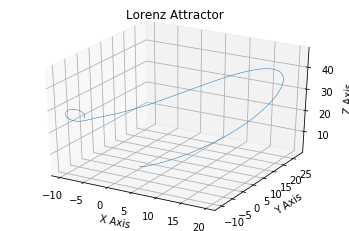

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.0001
num_steps = 13000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show();

In [3]:
u=xs;
v=ys;
w=zs;
t=np.arange(0,1.3001,0.0001,None);
print(len(t))
print(len(u))

13001
13001


In [4]:
l=np.array([t,u,v,w]);
l.shape

(4, 13001)

In [5]:
import torch
plt.style.use('seaborn-notebook')

# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.library_functions import library_basic_lorenz
from deepymod_torch.utilities import create_deriv_data, terms_definition

# Setting cuda if GPU is available
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(1)

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [6]:
#data = np.load('lorenz.npy', allow_pickle=True)
data=l

In [7]:
print('Shape of grid:', data.shape)

Shape of grid: (4, 13001)


In [8]:
X = data[0].reshape(data[0].size, 1)/2

In [9]:
X.shape

(13001, 1)

In [10]:
y=np.transpose((data[1].flatten(), data[2].flatten(), data[3].flatten()))/20

In [11]:
y.shape

(13001, 3)

In [12]:
y
y.shape

(13001, 3)

In [13]:
X

array([[0.0000e+00],
       [5.0000e-05],
       [1.0000e-04],
       ...,
       [6.4990e-01],
       [6.4995e-01],
       [6.5000e-01]])

In [14]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32,requires_grad=True)

In [15]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 1]) torch.Size([1000, 3])


In [16]:
config = {'input_dim': 1, 'hidden_dim': 50, 'layers': 5, 'output_dim': 3, 'library_function': library_basic_lorenz, 'library_args':{'poly_order': 1, 'diff_order': 1}}

In [17]:
model = DeepMod(config)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
X_input = create_deriv_data(X_train, config['library_args']['diff_order'])

In [19]:
X_input[1].shape

torch.Size([1000, 1, 1, 1])

In [20]:
q = model(X_input)

In [21]:
q[2][0].shape

torch.Size([1000, 5])

In [22]:
model.train(X_input, y_train, optimizer, 50000, type='deepmod')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
        100      0.20%            1693s   1.11e+00   1.05e+00   4.99e-02   7.76e-03 

KeyboardInterrupt: 

In [19]:
result = model(X_input)[0][0]

In [20]:
result = result.detach().numpy()

In [21]:
result.shape

(1000, 3)

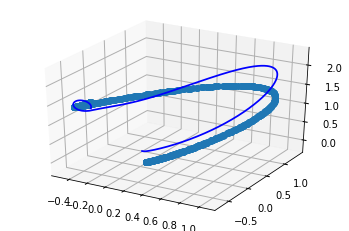

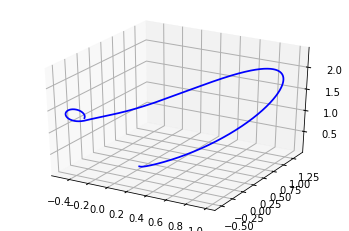

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1)
ax = fig.gca(projection='3d')

ax.plot(result[:,0],result[:,1],result[:,2],'o')
ax.plot(y[:,0],y[:,1],y[:,2],'b')
fig2=plt.figure(2)
bx=fig2.gca(projection='3d')
bx.plot(y[:,0],y[:,1],y[:,2],'b')

plt.show();